In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("songs").getOrCreate()
import numpy as np

# load local GloVe embeddings
vectors_file = 'song-vectors.txt'

with open(vectors_file, 'r') as f:
    vals = np.array([x.rstrip().split(' ') for x in f.readlines()])

In [6]:
from pyspark.mllib.clustering import KMeans
import re

# get numerical tags for each song
song_tags = '/project/cmsc25025/playlist/song-to-tags.txt'
with open(song_tags, 'r') as f:
    tag_dict = {}
    for x in f.readlines():
        id_tags = re.split(r'[,\tab\s]\s*',x.rstrip())
        # NOTE: some songs don't have tags
        tag_dict[id_tags[0]] = None if id_tags[1] == '#' else id_tags[1:]
              
# drop songs with no tags
rdd = spark.sparkContext.parallelize(vals).filter(lambda x: x[0] !='<unk>' and tag_dict[x[0]] is not None)
# perform kmeans on the song embeddings with k = 5
song_embeddings = rdd.map(lambda x: x[1:].astype(float))
model = KMeans.train(song_embeddings, 5, maxIterations=10, initializationMode="random")

In [7]:
from collections import Counter

# obtain cluster assignments
clusters = rdd.map(lambda x: (model.predict(x[1:].astype(float)),x[0]))

# obtain tags for all songs in a cluster
cluster_tags = clusters.map(lambda x: (x[0], tag_dict[x[1]])).reduceByKey(lambda a,b: a + b)
                      
# find 5 most common tags for each cluster
top5_tags_id = cluster_tags.map(lambda x: (x[0],Counter(x[1]).most_common(5)))

# map tag ids to word tags, print output
tag_hash = '/project/cmsc25025/playlist/tag_hash.txt'
with open(tag_hash, 'r') as f:
    word_tags = {}
    for x in f.readlines():
        id_word = x.rstrip().split(',')
        word_tags[id_word[0]] = id_word[1]
        
top5_tags_word = top5_tags_id.map(lambda x: [(x[0],[word_tags[i[0]] for i in x[1]])]).reduce(lambda a,b: a+b)
print top5_tags_word

[(0, [' pop', ' dance', ' hip-hop', ' rnb', ' hip hop']), (1, [' pop', ' favorites', ' rock', ' male vocalists', ' love']), (2, [' rock', ' pop', ' favorites', ' male vocalists', ' love']), (3, [' rock', ' alternative', ' alternative rock', ' hard rock', ' favorites']), (4, [' pop', ' favorites', ' rock', ' love', ' male vocalists'])]


There are two clusters that make a lot of sense. Cluster 0 clearly has to do with pop and hip-hop music, and cluster 3 clearly has to do with alternative/rock music. The other clusters have similar tags but in different orderings, and these tags are fairly vague and can apply to many genres of music (for example "favorites", "male vocalists", or "love"). These tags may be common throughout the whole dataset. In addition, a lot of the songs don't have tags which limits the dataset.

<IPython.core.display.Javascript object>


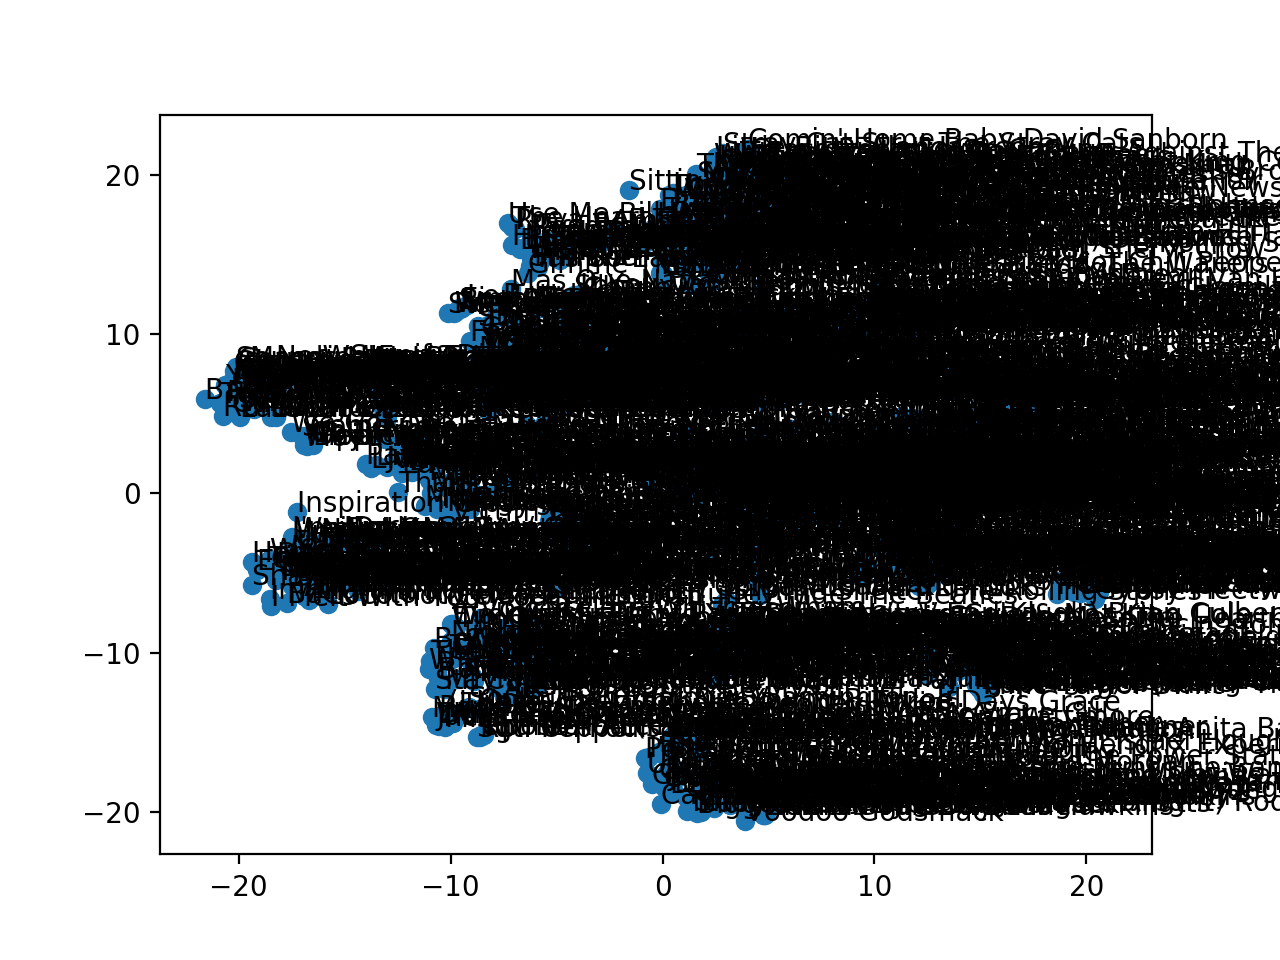

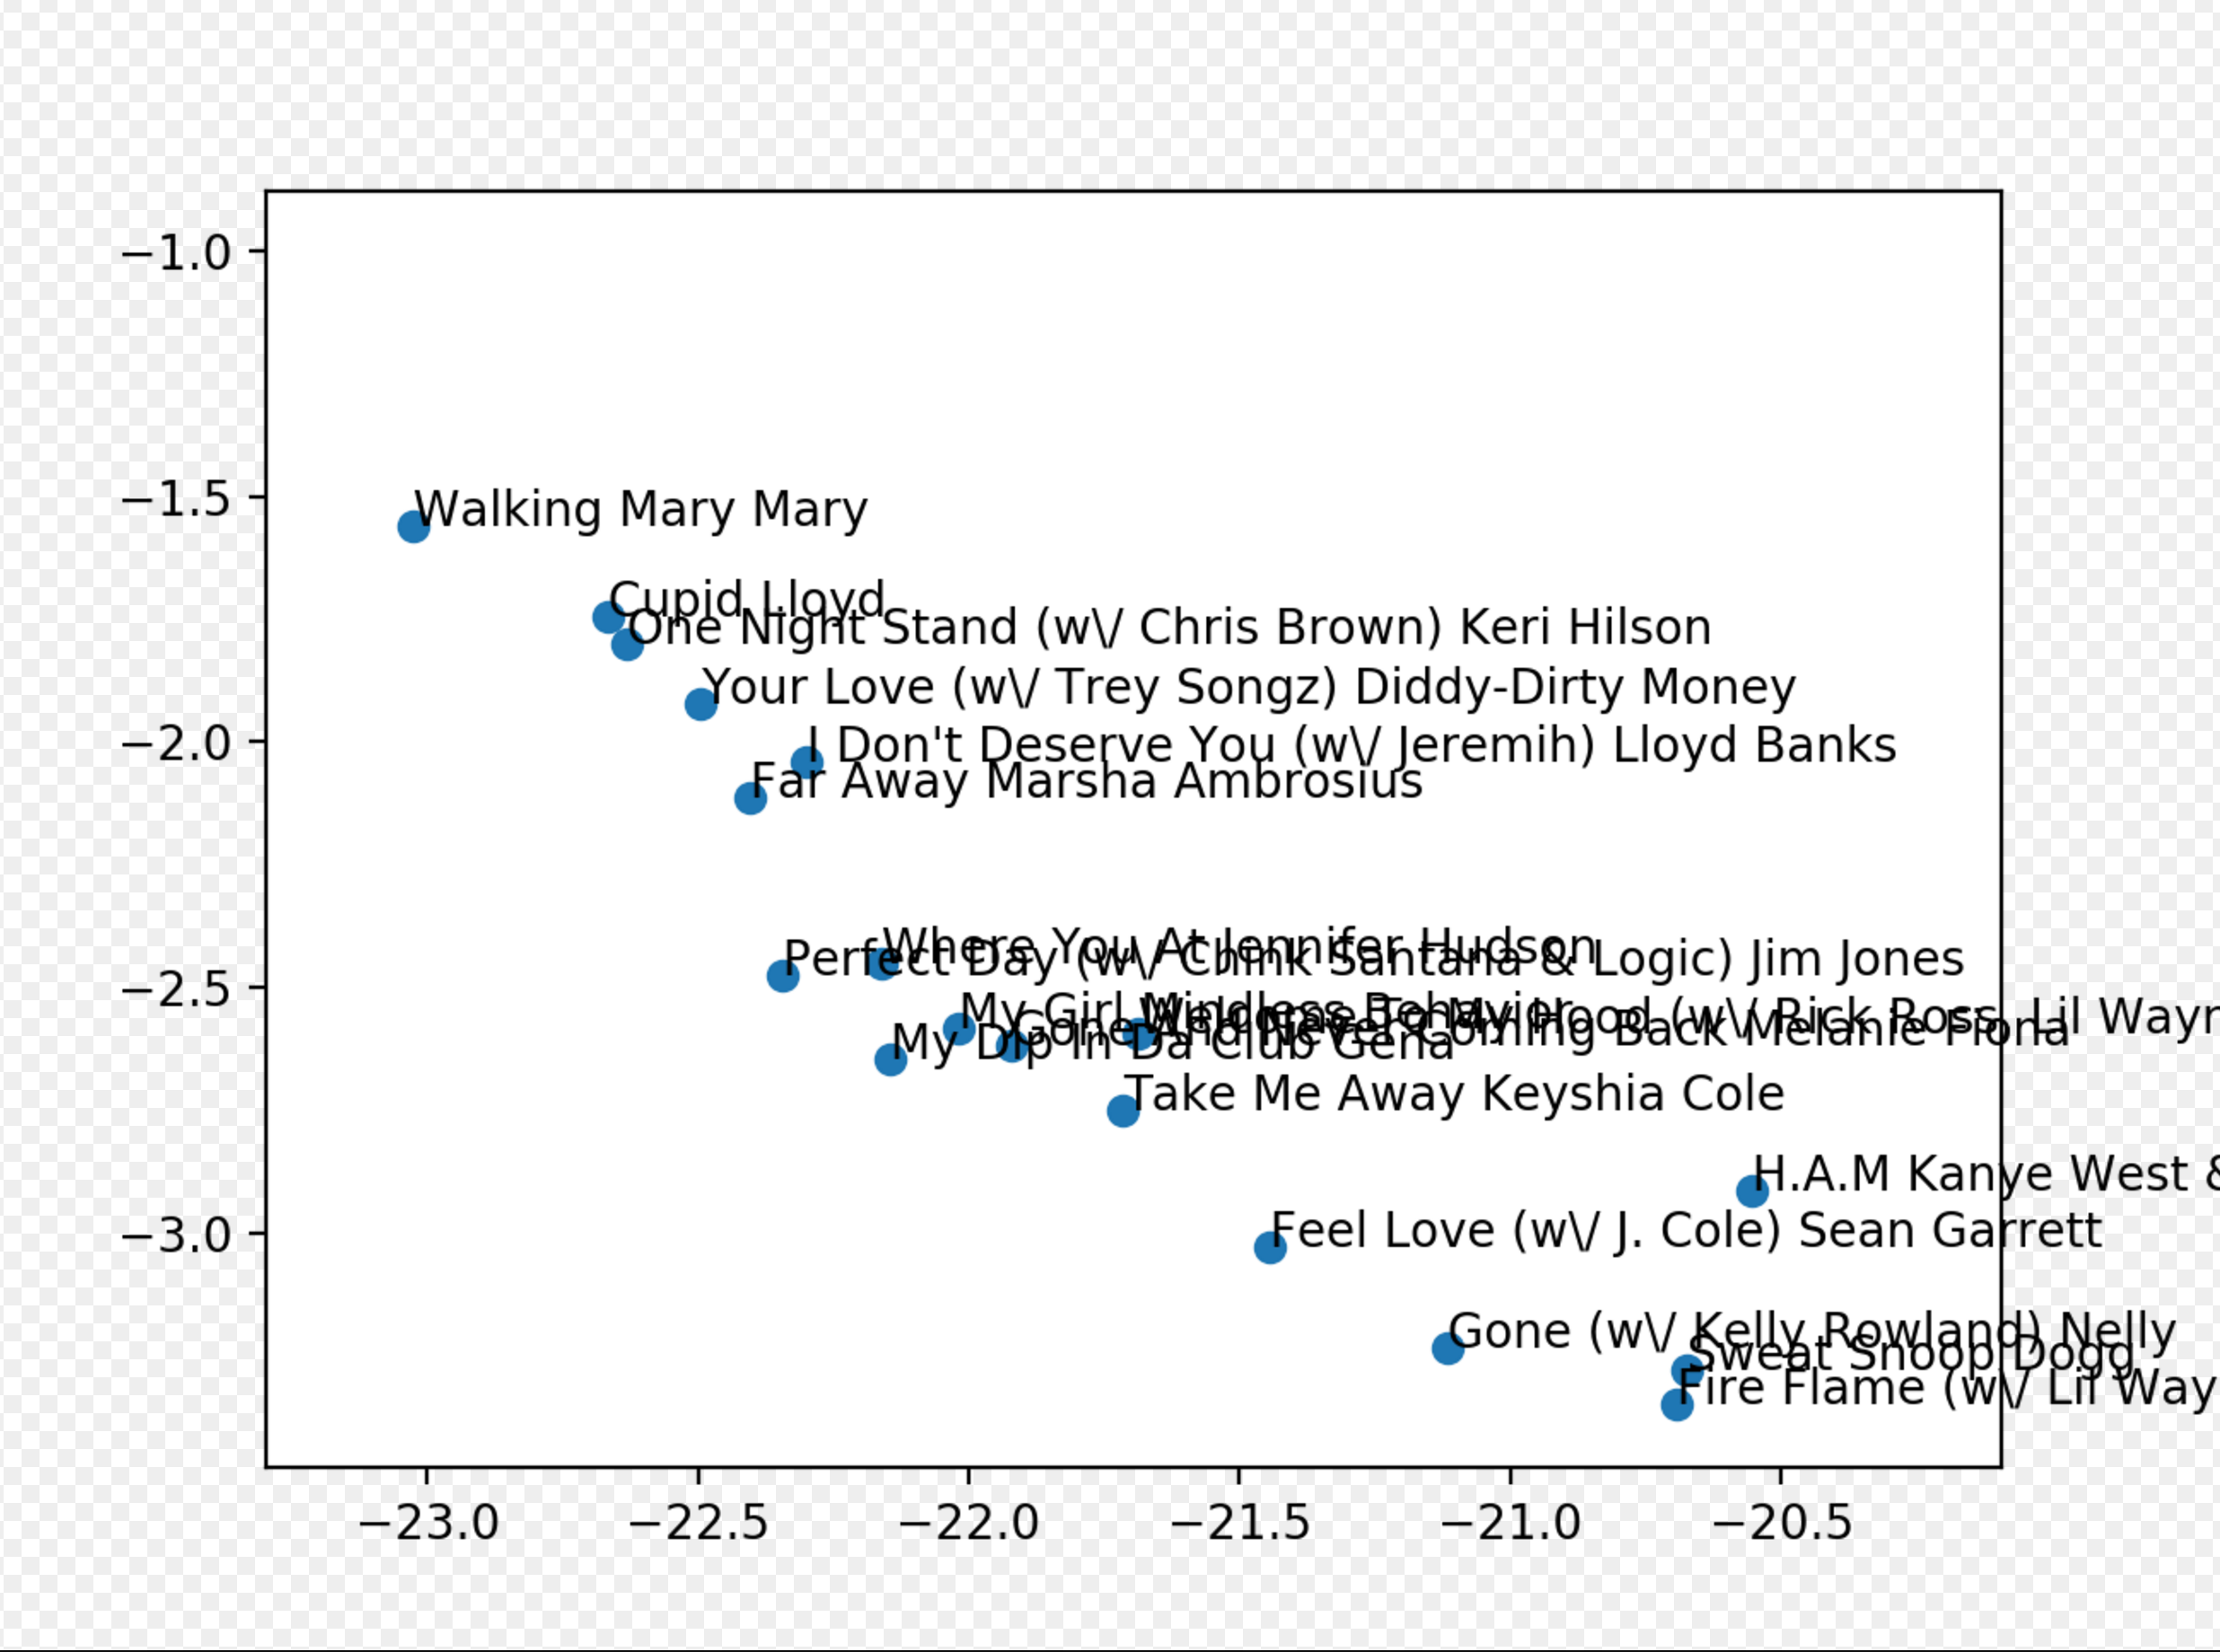

In [20]:
W = vals[:1000,1:].astype(float)

# load song info
song_info = '/project/cmsc25025/playlist/song_hash.txt'
with open(song_info, 'r') as f:
    song_dict = {}
    for x in f.readlines():
        id_name = x.rstrip().split('\t')
        song_dict[id_name[0]] = id_name[1] + " " + id_name[2]

# sort labels to be in same order as W
names = [song_dict[vals[i,0]] for i in range(1000)]

# use t-SNE to visualize the song embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W)
      
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(names, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),textcoords='offset points')
plt.show()

from IPython.display import Image 
Image(filename='Song Grouping.png')

The photo above shows an area of the plot where all of the songs are pop songs. These songs are all songs by similar artists, rappers/rnb artists, that sound similarly. It makes sense that these songs are grouped together. 

In [14]:
# load artist ids and their embedding vectors
vectors_file = 'artist-vectors.txt'
with open(vectors_file, 'r') as f:
    vals = np.array([x.rstrip().split(' ') for x in f.readlines()])
artist_embeddings = spark.sparkContext.parallelize(enumerate(vals[:,1:].astype(float)))

# create dictionary of id:artist
artist_info = '/project/cmsc25025/playlist/artist_hash.txt'
with open(artist_info, 'r') as f:
    id_dict = {}
    name_dict = {}
    for x in f.readlines():
        id_name = x.rstrip().split('\t')
        id_dict[id_name[0]] = id_name[1]
        name_dict[id_name[1]] = id_name[0]

tmp = [val[0] for val in vals]
        
# find the 5 closest embedding vectors to these artists
test_artists = ['The Beatles', 'The Red Hot Chili Peppers', 'Usher']
for artist in test_artists:
    print "5 closest vectors to %s" % artist
    v_artist = vals[tmp.index(name_dict[artist]),1:].astype(float)
    closest = artist_embeddings.map(lambda x: (x[0],np.linalg.norm(x[1] - v_artist)**2)).takeOrdered(6,key=lambda x: x[1])
    print [(i[1],id_dict[vals[i[0],0]]) for i in closest] # shouldn't the first be the artist themselves?

5 closest vectors to The Beatles
[(0.0, 'The Beatles'), (2.2224388285479999, 'Creedence Clearwater Revival'), (4.517632564506, 'The Kinks'), (4.5644049187900002, 'The Electric Light Orchestra'), (4.7139436207619987, 'America'), (4.8860878338029998, 'Bachman-Turner Overdrive')]
5 closest vectors to The Red Hot Chili Peppers
[(0.0, 'The Red Hot Chili Peppers'), (1.8981474563569998, 'Stone Temple Pilots'), (1.9375178601379999, 'Pearl Jam'), (2.1076854678370003, 'Nirvana'), (3.2711799441370002, 'Sublime'), (3.4845684150829999, 'Bush')]
5 closest vectors to Usher
[(0.0, 'Usher'), (3.0582779425510003, 'B.o.B'), (3.4442581678550002, 'Far East Movement'), (4.3242309995759989, 'Flo-Rida'), (4.4708949736820012, 'B.o.B.'), (5.354714903074, 'Jay Sean')]


The closest artist to each artist is themselves which makes sense. Then the next closest artists are similar artists. For usher there are other rappers and Rnb artists. For The red hot chili peppers there are other rock bands. For the beatles there are also similar sounding bands. 

<IPython.core.display.Javascript object>


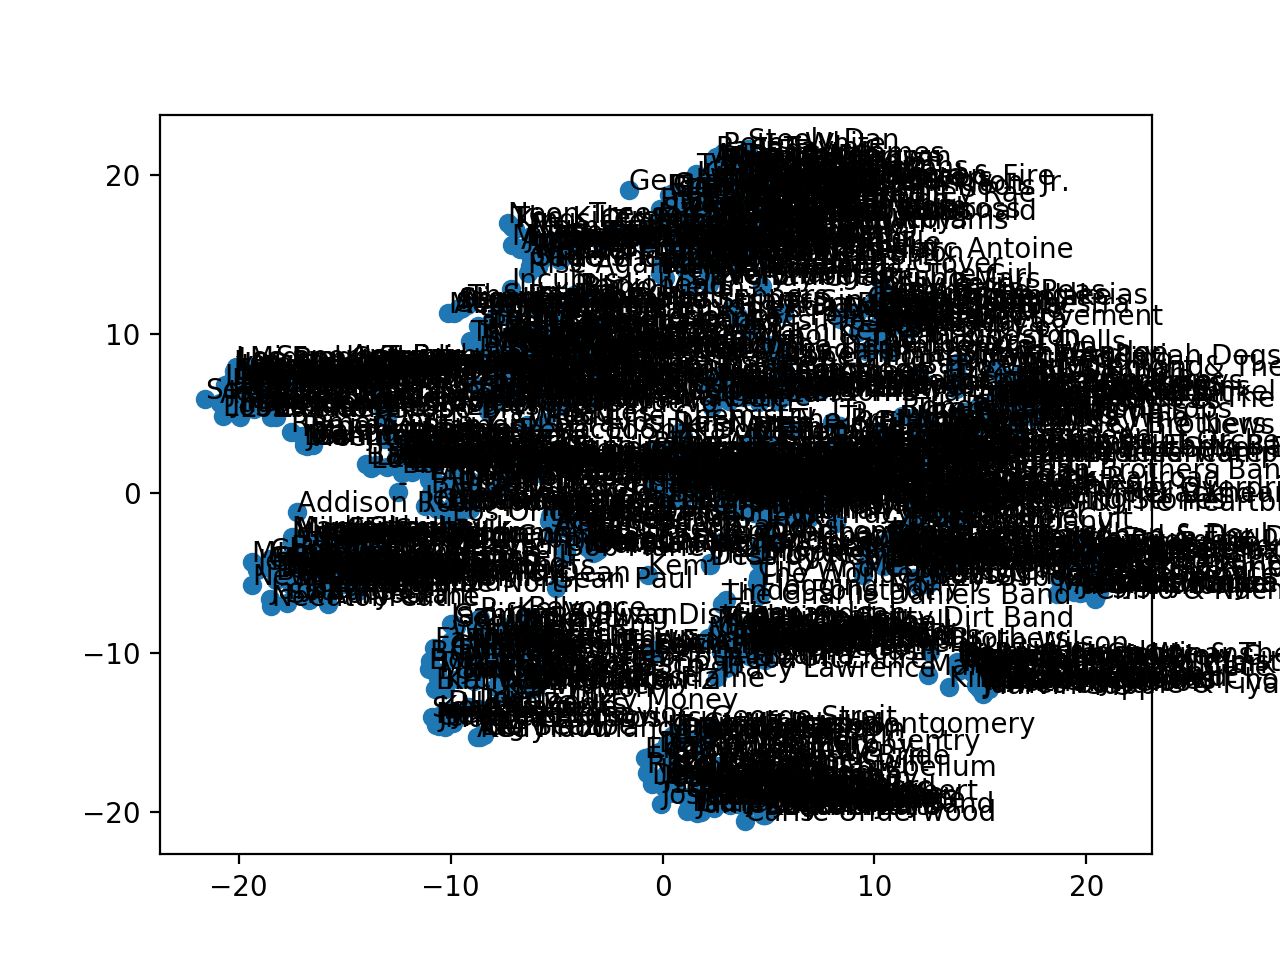

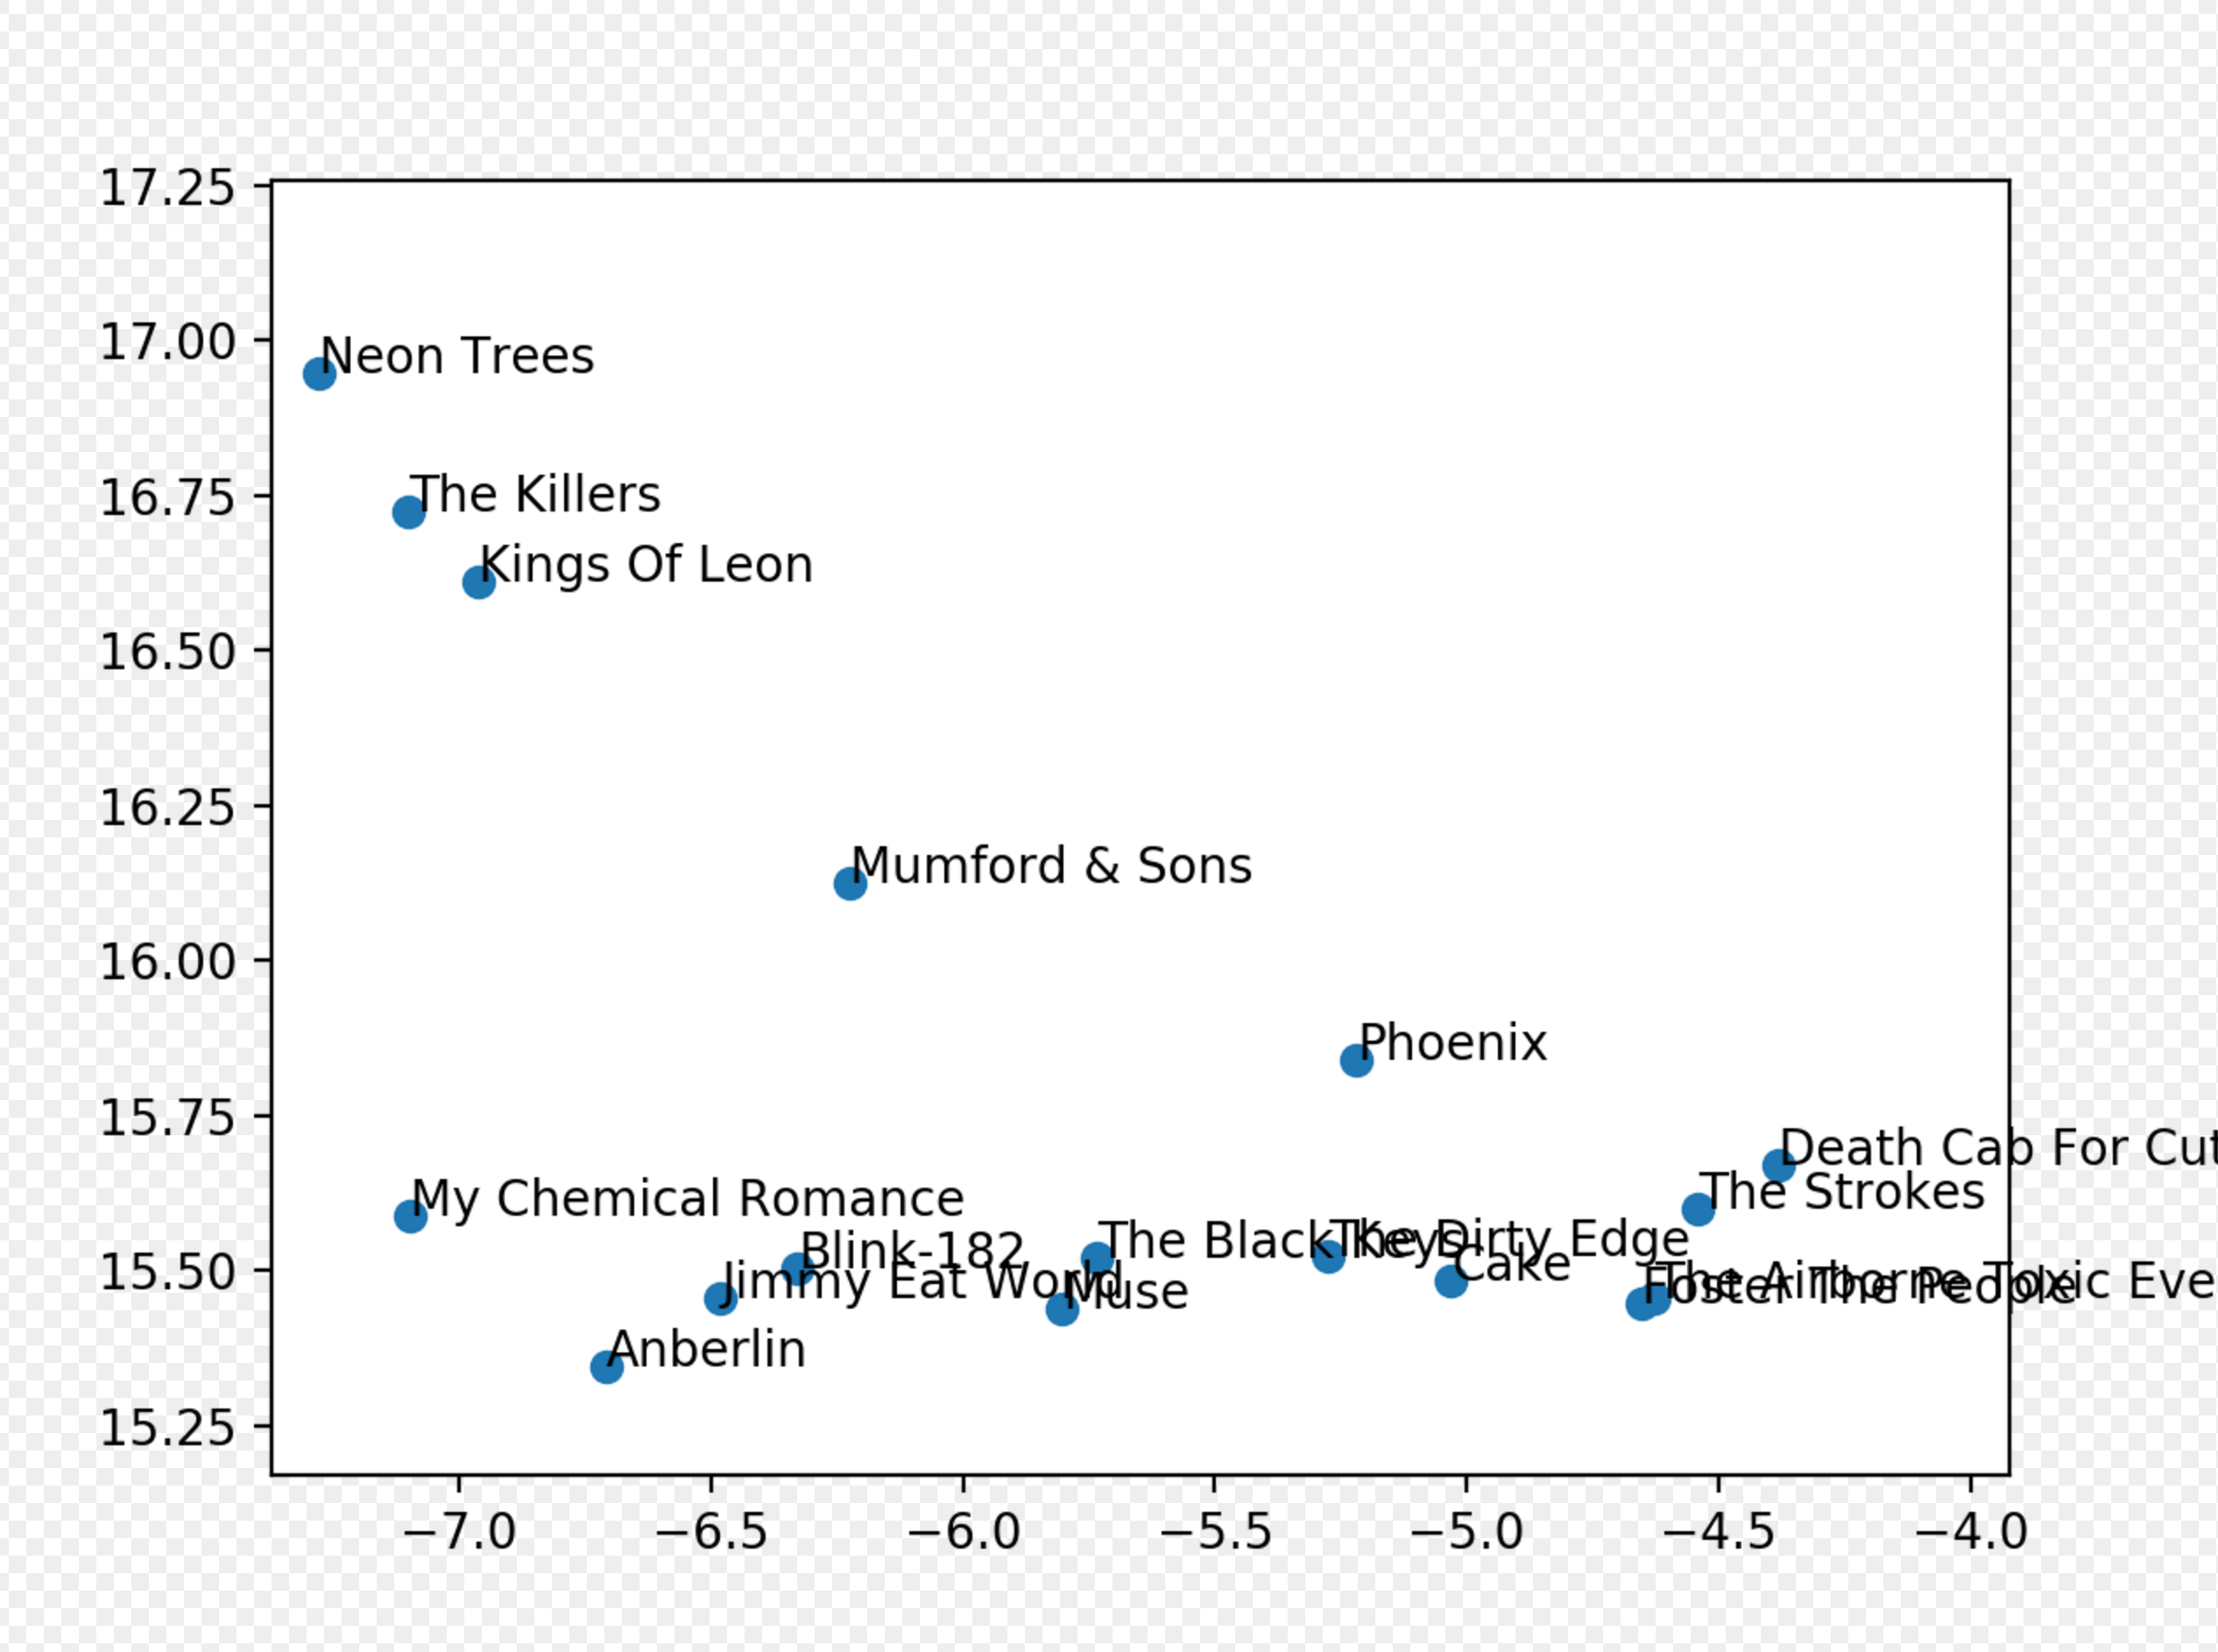

In [19]:
# use t-SNE to visualize the artist embeddings
W = vals[:1000,1:].astype(float)
names = [id_dict[ID] for ID in vals[:1000,0]]

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W)
      
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(names, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),textcoords='offset points')
plt.show()

from IPython.display import Image 
Image(filename='Artist Grouping.png')

This grouping makes a lot of sense. All of the bands shown above fall into the alternative/folk/indie rock genre. Mumford & sons, Phoenix, The strokes, Death Cab for Cutue, The black Keys, The killers all make similar sounding music. 